In [ ]:
from google.colab import files

print('Upload file {kaggle.json} :\n')
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Upload file {kaggle.json} :



Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download --unzip deepcontractor/musical-instrument-chord-classification

 98% 132M/135M [00:05<00:00, 28.3MB/s]
100% 135M/135M [00:05<00:00, 27.0MB/s]


In [ ]:
# for importing saved mfcc features
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import statistics
import json
from pickletools import optimize
import random
import librosa
from librosa import display
import matplotlib.pyplot as plt
import numpy as np
import math
from typing import List, Tuple
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
import datetime
import tensorflow as tf


PATH = "Audio_Files/"
JSON_PATH = "/content/mfcc_data.json"
JSON_PATH_DRIVE = "/content/drive/MyDrive/mfcc_data.json"
LABELS = ['Major','Minor']
SAMPLE_RATE = 22050

# Preprocessing

In [ ]:
def store_paths(path: str, labels: List[str]) -> List[Tuple[str, int]]:
  """ Store a tuple (file_path, label) for each file in the dataset

  Args:
    path (str): main directory of dataset
    labels (list[str]): names of data labels

  Returns:
    filenames (list[tuple[str, int]]): file path and label index of each data point
  """

  filenames = []
  for label in labels:
      dir_path = path + label
      for f in os.scandir(dir_path):
          filenames.append((dir_path + '/' + f.name, labels.index(label)))
  return filenames

In [ ]:
def balance_classes(filenames: List[Tuple[str, int]]) -> List[Tuple[str, int]]:
  """ Count number of samples for each class and balance the classes removing samples from the bigger one

  Args:
    filenames (list[tuple[str, int]]): file path and label index of each sample

  Returns:
    filenames (list[tuple[str, int]]): file path and label index of each sample after removing excess files
  """

  # show total count of files, and count for each class
  print('NUMBER OF FILES')
  total_files = len(filenames)
  major_files = len([label for _,label in filenames if label == 0])
  minor_files = len([label for _,label in filenames if label == 1])
  print('Total: ' + str(total_files))
  print('Major: ' + str(major_files))
  print('Minor: ' + str(minor_files))

  # removing excess files of class 'Major' to reach an equal count between the 2 classes
  count_diff = major_files - minor_files
  print('\nRemoving ' + str(count_diff) + ' excess files from class \'Major\'...\n')
  c = 0
  while c < count_diff:
      n = random.randint(0, major_files - c)
      if filenames[n][1] == 0:
        filenames.pop(n)
        c += 1

  # show new total count of files, and count for each class, which is now equal
  print('NUMBER OF FILES')
  total_files = len(filenames)
  major_files = len([label for _,label in filenames if label == 0])
  minor_files = len([label for _,label in filenames if label == 1])
  print('Total: ' + str(total_files))
  print('Major: ' + str(major_files))
  print('Minor: ' + str(minor_files))

  return filenames

In [ ]:
# create filenames (list of tuple with file_path and label for each sample) and balance the number of samples of the two classes
filenames = balance_classes(store_paths(PATH, LABELS))

# shuffle the data points
random.shuffle(filenames)

# save labels
labels = [label for _,label in filenames]

NUMBER OF FILES
Total: 859
Major: 502
Minor: 357

Removing 145 excess files from class 'Major'...

NUMBER OF FILES
Total: 714
Major: 357
Minor: 357


#Feature Extraction (MFCC & Chromagram)

##MFCC

In [ ]:
def compute_mfcc(filenames: List[Tuple[str, int]], sr: int, n_mfcc: int, n_fft: int, hop_length: int, max_length: int, n_frames: int) -> np.ndarray:
  """ For each file: load audio data and compute the mfccs

  Args:
    filenames (list[tuple[str, int]]): file path and label index of each sample
    sr (int): sample rate of the files
    n_mfcc (int): number of MFC coefficients to compute
    n_fft (int): length of the FFT window
    hop_length (int): number of samples between frames
    max_length (int): max length of audio files, when loading they will be cut to this value
    n_frames (int): length of files in number of frames, computed as math.ceil(max_length / hop_length)

  Returns:
    mfcc (np.ndarray): mfcc for each frame of each file
  """

  mfcc = np.empty((len(filenames), n_frames, n_mfcc))
  i = 0
  for f in filenames:

    if f[0][-13] == 'r':
      print("[" + str(i) + "] " + "Computing MFCC for " + f[0][-11:-4])
    elif f[0][-13] == '/':
      print("[" + str(i) + "] " + "Computing MFCC for " + f[0][-12:-4])
    else:
      print("[" + str(i) + "] " + "Computing MFCC for " + f[0][-13:-4])

    mfcc[i] = librosa.feature.mfcc(
                y=librosa.load(f[0], sr=SAMPLE_RATE)[0][:max_length],
                n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc).T
    i += 1

  # normalize the features
  scaler = StandardScaler()
  mfcc = scaler.fit_transform(mfcc.reshape(-1, mfcc.shape[-1])).reshape(mfcc.shape)

  return mfcc

In [ ]:
# mfcc parameters
n_mfcc = 13
n_fft = 2048
hop_length = 512
max_length = 47600  # longer files will be cut at this point
n_frames = math.ceil(max_length / hop_length)  # calculate the number of mfcc frames to be computed, which is constant

mfcc = compute_mfcc(filenames, SAMPLE_RATE, n_mfcc, n_fft, hop_length, max_length, n_frames)

[0] Computing MFCC for Minor_223
[1] Computing MFCC for Major_494
[2] Computing MFCC for Major_362
[3] Computing MFCC for Minor_97
[4] Computing MFCC for Major_370
[5] Computing MFCC for Minor_87
[6] Computing MFCC for Minor_355
[7] Computing MFCC for Major_80
[8] Computing MFCC for Major_355
[9] Computing MFCC for Minor_338
[10] Computing MFCC for Major_101
[11] Computing MFCC for Major_469
[12] Computing MFCC for Major_5
[13] Computing MFCC for Major_78
[14] Computing MFCC for Minor_82
[15] Computing MFCC for Minor_269
[16] Computing MFCC for Minor_107
[17] Computing MFCC for Major_310
[18] Computing MFCC for Minor_88
[19] Computing MFCC for Major_88
[20] Computing MFCC for Major_268
[21] Computing MFCC for Major_220
[22] Computing MFCC for Minor_343
[23] Computing MFCC for Major_288
[24] Computing MFCC for Minor_324
[25] Computing MFCC for Major_366
[26] Computing MFCC for Minor_131
[27] Computing MFCC for Major_79
[28] Computing MFCC for Minor_331
[29] Computing MFCC for Major_476


##Chromagram

In [ ]:
def compute_chroma(filenames: List[Tuple[str, int]], sr: int, n_chroma: int, n_fft: int, hop_length: int, max_length: int, n_frames: int) -> np.ndarray:
  """ For each file: load audio data and compute the chromagram

  Args:
    filenames (list[tuple[str, int]]): file path and label index of each sample
    sr (int): sample rate of the files
    n_chroma (int): number of chroma bins to produce
    n_fft (int): length of the FFT window
    hop_length (int): number of samples between frames
    max_length (int): max length of audio files, when loading they will be cut to this value
    n_frames (int): length of files in number of frames, computed as math.ceil(max_length / hop_length)

  Returns:
    chroma (np.ndarray): chroma for each frame of each file
  """

  chroma = np.empty((len(filenames), n_frames, n_chroma))
  i = 0
  for f in filenames:

    if f[0][-13] == 'r':
      print("[" + str(i) + "] " + "Computing chromagram for " + f[0][-11:-4])
    elif f[0][-13] == '/':
      print("[" + str(i) + "] " + "Computing chromagram for " + f[0][-12:-4])
    else:
      print("[" + str(i) + "] " + "Computing chromagram for " + f[0][-13:-4])

    chroma[i] = librosa.feature.chroma_stft(
                y=librosa.load(f[0], sr=SAMPLE_RATE)[0][:max_length],
                n_fft=n_fft, hop_length=hop_length, n_chroma=n_chroma).T
    i += 1

  # normalize the features
  scaler = StandardScaler()
  chroma = scaler.fit_transform(chroma.reshape(-1, chroma.shape[-1])).reshape(chroma.shape)

  return chroma

In [ ]:
# chroma parameters
n_chroma = 12
n_fft = 2048
hop_length = 512
max_length = 47600  # longer files will be cut at this point
n_frames = math.ceil(max_length / hop_length)  # calculate the number of frames to be computed, which is constant

chroma = compute_chroma(filenames, SAMPLE_RATE, n_chroma, n_fft, hop_length, max_length, n_frames)

[0] Computing chromagram for Minor_223
[1] Computing chromagram for Major_494
[2] Computing chromagram for Major_362
[3] Computing chromagram for Minor_97
[4] Computing chromagram for Major_370
[5] Computing chromagram for Minor_87
[6] Computing chromagram for Minor_355
[7] Computing chromagram for Major_80
[8] Computing chromagram for Major_355
[9] Computing chromagram for Minor_338
[10] Computing chromagram for Major_101
[11] Computing chromagram for Major_469
[12] Computing chromagram for Major_5
[13] Computing chromagram for Major_78
[14] Computing chromagram for Minor_82
[15] Computing chromagram for Minor_269
[16] Computing chromagram for Minor_107
[17] Computing chromagram for Major_310
[18] Computing chromagram for Minor_88
[19] Computing chromagram for Major_88
[20] Computing chromagram for Major_268
[21] Computing chromagram for Major_220
[22] Computing chromagram for Minor_343
[23] Computing chromagram for Major_288
[24] Computing chromagram for Minor_324
[25] Computing chro

# Length of samples (in MFCC frames)

In [ ]:
max = 0
min = 100
tot = 0
for i in range(0,len(mfcc)):
  print(str(i) + ': ' + str(len(mfcc[i])))
  if len(mfcc[i]) > max:
    max = len(mfcc[i])
  if len(mfcc[i]) < min:
    min = len(mfcc[i])
  tot += len(mfcc[i])

print('\nTot samples: ' + str(len(mfcc)) + '\nMin length: ' + str(min) + ' frames' + '\nMax length: ' + str(max) + ' frames' + '\nAvg length: ' + str(round(tot / len(mfcc), 2)) + ' frames')

0: 95
1: 95
2: 95
3: 100
4: 95
5: 97
6: 97
7: 100
8: 95
9: 97
10: 97
11: 97
12: 97
13: 97
14: 100
15: 100
16: 97
17: 97
18: 95
19: 97
20: 97
21: 97
22: 95
23: 97
24: 100
25: 97
26: 97
27: 97
28: 100
29: 100
30: 97
31: 95
32: 97
33: 97
34: 95
35: 97
36: 97
37: 100
38: 95
39: 97
40: 97
41: 97
42: 95
43: 97
44: 97
45: 95
46: 95
47: 100
48: 100
49: 97
50: 95
51: 97
52: 97
53: 97
54: 100
55: 95
56: 95
57: 95
58: 95
59: 100
60: 100
61: 95
62: 97
63: 95
64: 95
65: 95
66: 100
67: 95
68: 100
69: 95
70: 95
71: 95
72: 97
73: 95
74: 97
75: 97
76: 100
77: 100
78: 95
79: 97
80: 100
81: 95
82: 95
83: 95
84: 100
85: 95
86: 100
87: 97
88: 95
89: 95
90: 97
91: 95
92: 95
93: 100
94: 95
95: 100
96: 97
97: 95
98: 97
99: 95
100: 95
101: 100
102: 95
103: 95
104: 95
105: 95
106: 95
107: 97
108: 95
109: 97
110: 100
111: 95
112: 100
113: 97
114: 97
115: 95
116: 97
117: 100
118: 95
119: 100
120: 95
121: 100
122: 95
123: 97
124: 95
125: 95
126: 97
127: 100
128: 95
129: 95
130: 95
131: 95
132: 97
133: 95
134: 95
1

# Tests on a data point

In [ ]:
#filenames = store_paths(PATH, LABELS)
sample = 142
signal, sr = librosa.load(filenames[sample][0])

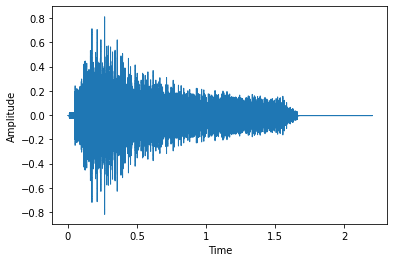

In [ ]:
# show waveplot
librosa.display.waveshow(signal, sr=SAMPLE_RATE)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

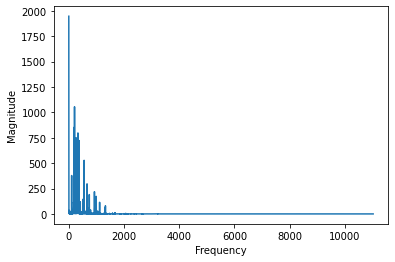

In [ ]:
# compute and show fourier transform
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
left_magnitude = magnitude[:int(len(frequency)/2)]
left_frequency = frequency[:int(len(frequency)/2)]
plt.plot(left_frequency, left_magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

(12, 97)


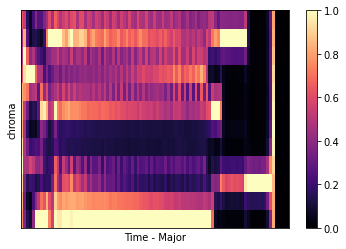

In [ ]:
# compute and show chromagram of single sample
signal_harmonic = librosa.feature.chroma_stft(signal, sr)
print(signal_harmonic.shape)
librosa.display.specshow(signal_harmonic, sr=sr)
plt.xlabel('Time - ' + LABELS[filenames[sample][1]])
plt.ylabel('chroma')
plt.colorbar()
plt.show()

[[-424.12927   -386.36026   -350.03452   ... -569.5452    -569.5452
  -569.5452   ]
 [ 118.53575    178.43484    222.12796   ...    0.           0.
     0.       ]
 [  17.47393     56.17586     71.4595    ...    0.           0.
     0.       ]
 ...
 [   8.780928    -6.0176735   -7.59746   ...    0.           0.
     0.       ]
 [   6.590527    -9.690424    -9.197842  ...    0.           0.
     0.       ]
 [   7.055627    -6.5538697  -11.160372  ...    0.           0.
     0.       ]]


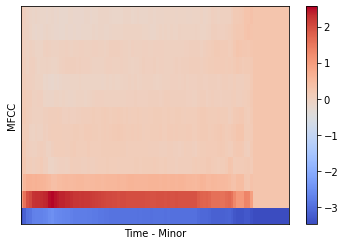

In [ ]:
# compute and show MFCCs of single sample
n_fft = 2048
hop_length = 512
mfcc = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
print(mfcc)
mfcc_norm = StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc_norm, sr=SAMPLE_RATE, hop_length=hop_length)
plt.xlabel('Time - ' + LABELS[filenames[sample][1]])
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

# K-means clustering

In [ ]:
def kmeans(features: np.ndarray, n_features: int, n_frames: int):
  """ Compute K-Means on MFCCs after reshaping them to 1 dimension, normalizing, and applying PCA to reduce the number of features

  Args:
    features (np.ndarray): array of features
    n_features (int): number of features computed
    n_frames (int): number of frames per data point
  """

  features_new = np.empty((len(features), n_features))
  i = 0
  for e in features:
    features_new[i] = e.mean(axis=0)
    i += 1

  # normalize data: z = (x - u) / s where u is the mean and s is the standard deviation
  features_norm = StandardScaler().fit_transform(features_new)

  # apply PCA
  pca = PCA(n_components=0.90)
  features_reduced = pca.fit_transform(features_norm)
  print("\nApplying PCA...\nOriginal number of features:", features_norm.shape[1])
  print("Reduced number of features:", features_reduced.shape[1])

  # compute K-Means
  print("\nComputing KMeans on the data...")
  kmeans = KMeans(n_clusters=2, n_init=10)
  clusters = kmeans.fit_predict(features_reduced)

  # visualize K-Means clusters
  filtered_label0 = features_reduced[clusters == 0]
  filtered_label1 = features_reduced[clusters == 1]
  plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'red', label = 0)
  plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'black', label = 1)
  plt.legend()
  plt.show()


Applying PCA...
Original number of features: 13
Reduced number of features: 6

Computing KMeans on the data...


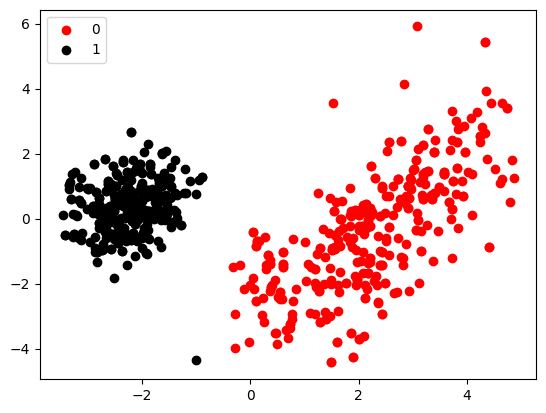

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# cluster MFCC
kmeans(mfcc, n_mfcc, n_frames)


Applying PCA...
Original number of features: 12
Reduced number of features: 10

Computing KMeans on the data...


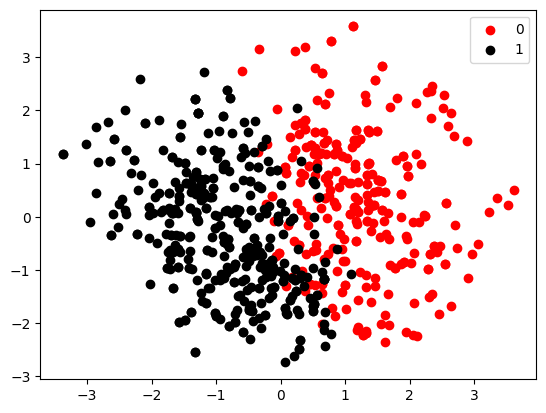

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# cluster chroma
kmeans(chroma, n_chroma, n_frames)

# Decision Tree

In [ ]:
def decision_tree(features: np.ndarray, n_features: int, n_frames: int, labels: List[int]):
  """ Training and testing of a Decision Tree classifier

  Args:
    features (np.ndarray): array of features
    n_features (int): number of features computed
    n_frames (int): number of frames per data point
    labels (list[int]): labels of  samples
  """

  # create train-test partitions
  inputs_train, inputs_test, targets_train, targets_test = train_test_split(features, labels, test_size=0.2)

  targets_train = np.array(targets_train)
  targets_test = np.array(targets_test)

  # reshape the input from 2-D to 1-D
  inputs_train_new = np.empty((len(inputs_train), n_frames * n_features))
  inputs_test_new = np.empty((len(inputs_test), n_frames * n_features))

  i = 0
  for e in inputs_train:
      inputs_train_new[i] = np.ravel(inputs_train[i])
      i += 1

  i = 0
  for e in inputs_test:
      inputs_test_new[i] = np.ravel(inputs_test[i])
      i += 1

  # create a Decision Tree classifier with sklearn
  model = DecisionTreeClassifier(random_state=0)

  # 10-fold cross validation
  scores = cross_val_score(model, inputs_train_new, targets_train, cv=10)
  print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
  print(f"Scores: {scores}")

  model.fit(inputs_train_new, targets_train)  # train the model

  pred_y = model.predict(inputs_test_new)  # predict
  predictions = model.predict_proba(inputs_test_new)

  # print results
  cm = confusion_matrix(targets_test, pred_y)
  acc = accuracy_score(targets_test, pred_y)
  print("\nAccuracy Score: {:.2f}".format(acc))
  print("\nConfusion Matrix:")
  disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
  disp_cm.plot()
  plt.show()

  print("\nROC curve:")
  disp_roc = RocCurveDisplay.from_predictions(targets_test, [p[1] for p in predictions], name="Decision Tree")
  plt.show()

0.71 accuracy with a standard deviation of 0.05
Scores: [0.70689655 0.73684211 0.73684211 0.68421053 0.71929825 0.59649123
 0.68421053 0.70175439 0.80701754 0.70175439]

Accuracy Score: 0.78

Confusion Matrix:


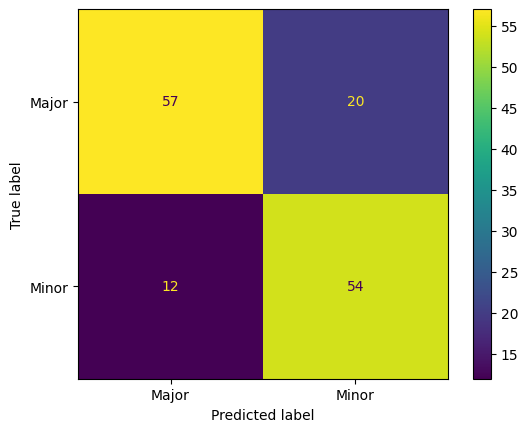


ROC curve:


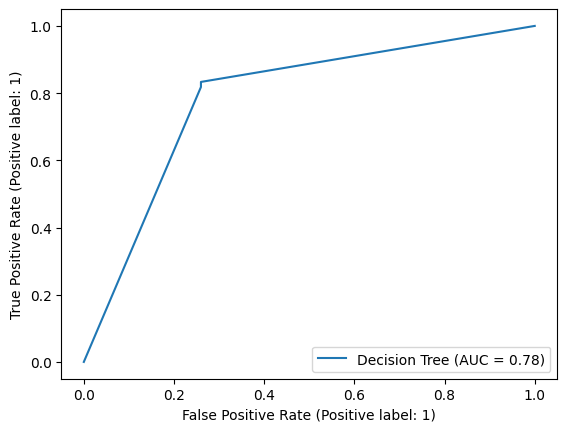

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_score

# train and test on mfcc
decision_tree(mfcc, n_frames, n_mfcc, labels)

0.71 accuracy with a standard deviation of 0.07
Scores: [0.74137931 0.75438596 0.64912281 0.70175439 0.70175439 0.75438596
 0.71929825 0.63157895 0.59649123 0.84210526]

Accuracy Score: 0.78

Confusion Matrix:


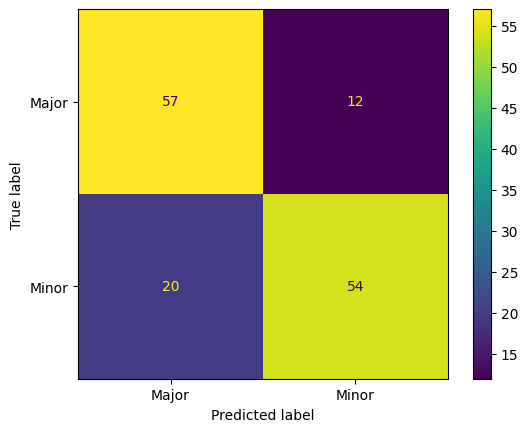


ROC curve:


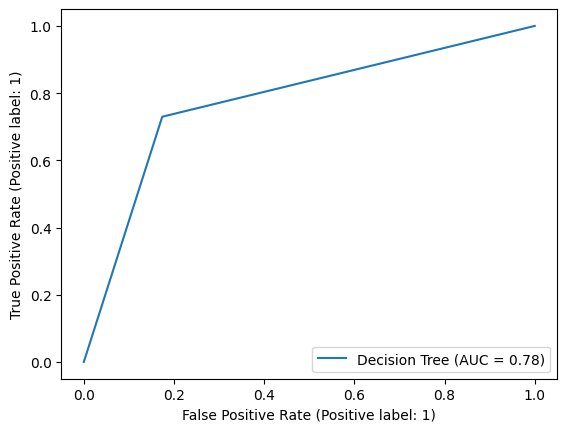

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# train and test on chroma
decision_tree(chroma, n_frames, n_chroma, labels)

# K-Nearest Neighbors

In [ ]:
def knn(features: np.ndarray, n_features: int, n_frames: int, labels: List[int]):
  """ Training and testing of a K-nearest neighbors classifier

  Args:
    features (np.ndarray): array of features
    n_features (int): number of features computed
    n_frames (int): number of frames per data point
    labels (list[int]): labels of  samples
  """

  # create train-test partitions
  inputs_train, inputs_test, targets_train, targets_test = train_test_split(features, labels, test_size=0.2)

  targets_train = np.array(targets_train)
  targets_test = np.array(targets_test)

  # reshape the input from 2-D to 1-D
  inputs_train_new = np.empty((len(inputs_train), n_frames * n_features))
  inputs_test_new = np.empty((len(inputs_test), n_frames * n_features))

  i = 0
  for e in inputs_train:
      inputs_train_new[i] = np.ravel(inputs_train[i])
      i += 1

  i = 0
  for e in inputs_test:
      inputs_test_new[i] = np.ravel(inputs_test[i])
      i += 1

  # create a K-nearest neighbors classifier model with sklearn

  model = KNeighborsClassifier()  # build the model

  # 10-fold cross validation
  scores = cross_val_score(model, inputs_train_new, targets_train, cv=10)
  print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
  print(f"Scores: {scores}")

  model.fit(inputs_train_new, targets_train)  # train the model

  pred_y = model.predict(inputs_test_new)  # predict
  predictions = model.predict_proba(inputs_test_new)

  # print results
  cm = confusion_matrix(targets_test, pred_y)
  acc = accuracy_score(targets_test, pred_y)
  print("\nAccuracy Score: {:.2f}".format(acc))
  print("\nConfusion Matrix:")
  disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
  disp_cm.plot()
  plt.show()

  print("\nROC curve:")
  disp_roc = RocCurveDisplay.from_predictions(targets_test, [p[1] for p in predictions], name="k-NN")
  plt.show()

0.63 accuracy with a standard deviation of 0.05
Scores: [0.63793103 0.63157895 0.54385965 0.63157895 0.71929825 0.63157895
 0.57894737 0.63157895 0.68421053 0.56140351]

Accuracy Score: 0.70

Confusion Matrix:


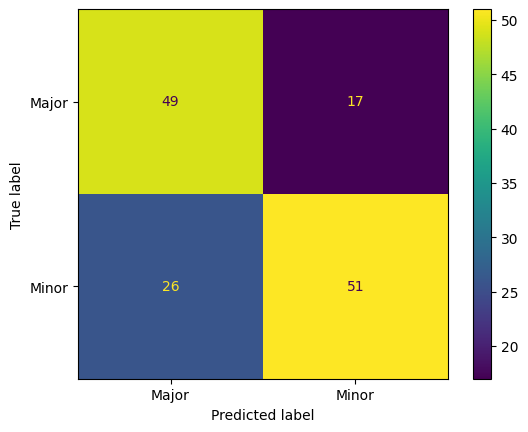


ROC curve:


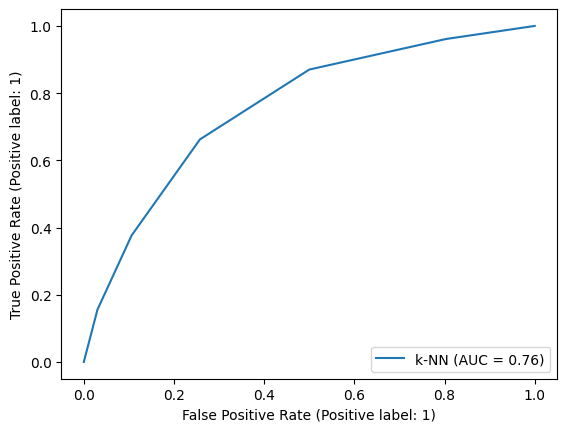

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# train and test on mfcc
knn(mfcc, n_frames, n_mfcc, labels)

0.63 accuracy with a standard deviation of 0.06
Scores: [0.65517241 0.56140351 0.66666667 0.63157895 0.71929825 0.68421053
 0.63157895 0.64912281 0.50877193 0.63157895]

Accuracy Score: 0.64

Confusion Matrix:


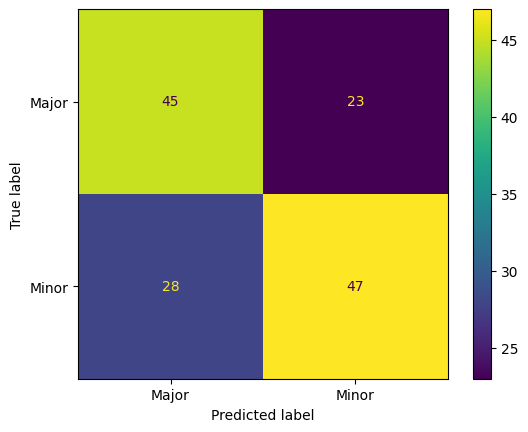


ROC curve:


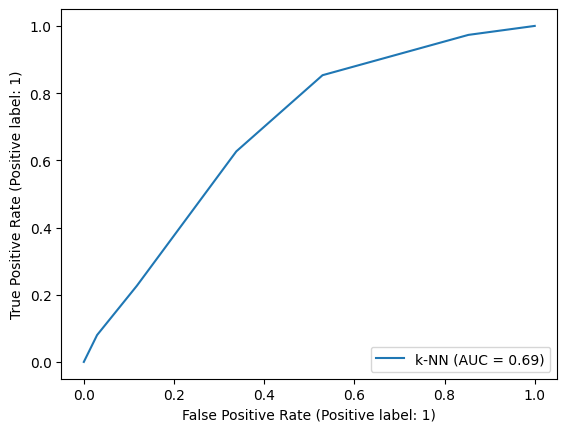

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# train and test on chroma
knn(chroma, n_frames, n_chroma, labels)

# MLP

In [ ]:
def create_MLP(input_shape: Tuple[int], n_neurons_1: int, n_neurons_2: int, n_neurons_3: int, dropout: int, reg: str) -> keras.Model:
  """ Creating the Multilayer Perceptron

  Args:
    input_shape (tuple[int]): input shape of the model
    n_neurons_1 (int): number of neurons in the first layer
    n_neurons_2 (int): number of neurons in the second layer
    n_neurons_3 (int): number of neurons in the third layer
    dropout (int): percentage of dropout after each layer
    reg (str): regularization of the layers kernel

  Returns:
    model (keras.Model): MLP model
  """
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(n_neurons_1, activation='relu', kernel_regularizer=reg),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(n_neurons_2, activation='relu', kernel_regularizer=reg),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(n_neurons_3, activation='relu', kernel_regularizer=reg),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(2, activation='softmax')
    ])

  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

In [ ]:
def tune_MLP(features: np.ndarray, labels: np.ndarray):
  """ Tuning of the parameters of a Multilayer Perceptron

  Args:
    features (np.ndarray): array of features
    labels (np.ndarray): labels of  samples

  Returns:
    best_parameters (list[int]): best combination of parameters found by GridSearch
  """
  input_shape = (features.shape[1], features.shape[2])

  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn = create_MLP, verbose = 0)

  # define the grid search parameters
  hparams = dict(input_shape = [input_shape],
                 n_neurons_1 = [32, 64, 128, 256],
                 n_neurons_2 = [16, 32, 64, 128],
                 n_neurons_3 = [8, 16, 32, 64],
                 dropout = [0.1, 0.2, 0.3],
                 reg = ['l1_l2', None])

  grid = GridSearchCV(estimator = model, param_grid = hparams, scoring='accuracy', n_jobs=-1)
  grid_result = grid.fit(features, labels)
  score = grid_result.best_score_
  best_parameters = grid_result.best_params_
  print("Using the Grid Search, the best score is {:.2f} using {}".format(score, best_parameters))

  return best_parameters

In [ ]:
def train_MLP(inputs_train: np.ndarray, inputs_val: np.ndarray, targets_train: np.ndarray, targets_val: np.ndarray, best_parameters: List[int]) -> keras.Model:
  """ Training of a Multilayer Perceptron

  Args:
    inputs_train (np.ndarray): features of train set
    inputs_val (np.ndarray): features of valdiation set
    targets_train (np.ndarray): labels of train set
    targets_val (np.ndarray): labels of validation set
    best_parameters (list[int]): best combination of parameters found by GridSearch

  Returns:
    model (keras.Model): trained MLP model
  """

  # convert best parameters dictionary to list
  best_params = []
  i=0
  for e in best_parameters.values():
    best_params.append(e)
    i+=1

  # create the model using the best configuration of hyperparameters
  model = create_MLP(best_params[1], best_params[2], best_params[3], best_params[4], best_params[0],  best_params[5])

  # train model
  model.fit(x=inputs_train, y=targets_train, validation_data=(inputs_val, targets_val), epochs=50, batch_size=16)

  return model

In [ ]:
def evaluate_MLP(model: keras.Model, inputs_test: np.ndarray, targets_test: np.ndarray):
  """ Evaluating the MLP

  Args:
    model (keras.Model): trained MLP model
    inputs_test (np.ndarray): features of test set
    targets_test (np.ndarray): labels of test set
  """

  predictions = model.predict(inputs_test)
  pred_y = []
  for pred in predictions:
    if pred[0] > pred[1]:
      pred_y.append(0)
    else:
      pred_y.append(1)

  # print results
  cm = confusion_matrix(targets_test, pred_y)
  acc = accuracy_score(targets_test, pred_y)
  print("\nAccuracy Score: {:.2f}".format(acc))
  print("\nConfusion Matrix:")
  disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
  disp_cm.plot()
  plt.show()

  print("\nROC curve:")
  disp_roc = RocCurveDisplay.from_predictions(targets_test, [p[1] for p in predictions], name="MLP")
  plt.show()

## Train and test on MFCC

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 1209)              0         
                                                                 
 dense_28 (Dense)            (None, 32)                38720     
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 64)                2112      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dropout_23 (Dropout)        (None, 64)               

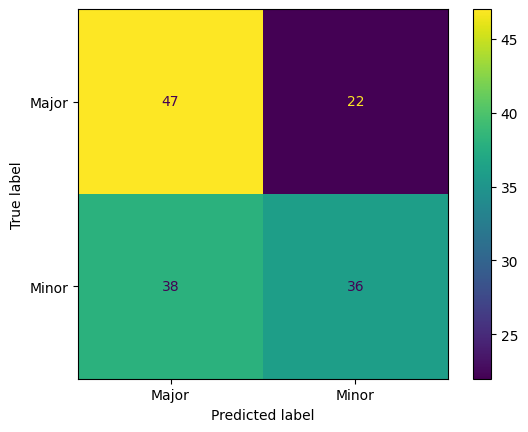


ROC curve:


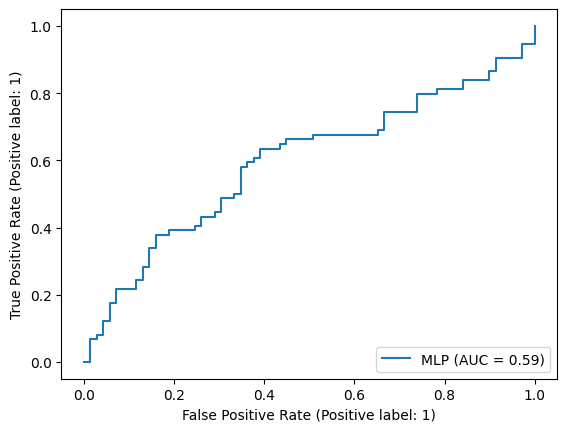

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

# create train-test partitions
inputs_train, inputs_test, targets_train, targets_test = train_test_split(mfcc, labels, test_size=0.2)
inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs_train, targets_train, test_size=0.2)
targets_train = np.array(targets_train)
targets_val = np.array(targets_val)
targets_test = np.array(targets_test)

# tune on MFCC train set
# best_parameters = tune_MLP(inputs_train, targets_train)
best_parameters = {'dropout': 0.3, 'input_shape': (93, 13), 'n_neurons_1': 32, 'n_neurons_2': 64, 'n_neurons_3': 64, 'reg': 'l1_l2'}

# train on MFCC with best parameters
mlp = train_MLP(inputs_train, inputs_val, targets_train, targets_val, best_parameters)

# evaluate MLP on the test set
evaluate_MLP(mlp, inputs_test, targets_test)

## Train and test on chroma

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 1116)              0         
                                                                 
 dense_32 (Dense)            (None, 256)               285952    
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 128)               32896     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 32)                4128      
                                                                 
 dropout_26 (Dropout)        (None, 32)               

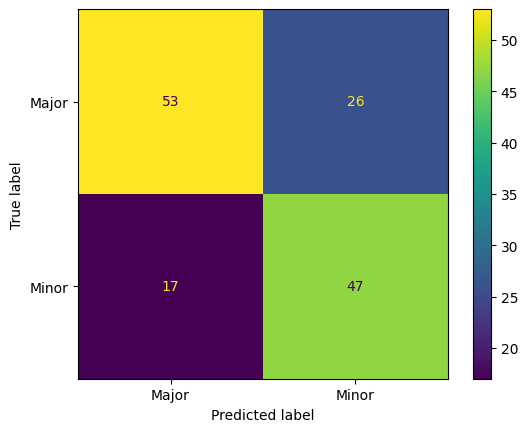


ROC curve:


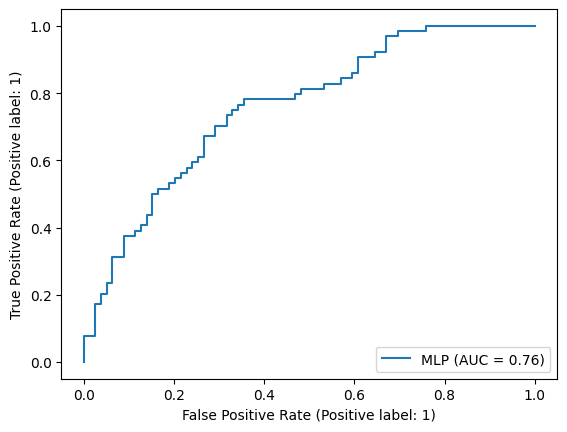

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

# create train-test partitions
inputs_train, inputs_test, targets_train, targets_test = train_test_split(chroma, labels, test_size=0.2)
inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs_train, targets_train, test_size=0.2)
targets_train = np.array(targets_train)
targets_val = np.array(targets_val)
targets_test = np.array(targets_test)

# tune on chroma
# best_parameters = tune_MLP(inputs_train, targets_train)
best_parameters = {'dropout': 0.1, 'input_shape': (93, 12), 'n_neurons_1': 256, 'n_neurons_2': 128, 'n_neurons_3': 32, 'reg': None}

# train on chroma with best parameters
mlp = train_MLP(inputs_train, inputs_val, targets_train, targets_val, best_parameters)

# evaluate MLP on the test set
evaluate_MLP(mlp, inputs_test, targets_test)

# CNN

In [ ]:
def create_CNN(input_shape: Tuple[int], n_filters: int, size_filters: int, n_neurons: int):
  """ Creating the Convolutional Neural Network

  Args:
    input_shape (tuple[int]): input shape of the model
    n_filters (int): number of filters in the convolution layer
    size_filters (int): size of filters in the convolution layer
    n_neurons (int): number of neurons in the dense layer
  """

  model = keras.Sequential([
      keras.layers.Conv2D(n_filters, (size_filters,size_filters), activation='relu', input_shape=input_shape),
      keras.layers.MaxPool2D((2,2), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Flatten(),
      keras.layers.Dense(n_neurons, activation='relu'),
      keras.layers.Dense(2, activation='softmax')
      ])

  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

In [ ]:
def tune_CNN(features: np.ndarray, labels: np.ndarray):
  """ Tuning of the parameters of the CNN

  Args:
    features (np.ndarray): array of features
    labels (list[int]): labels of  samples
  """

  # add 4th dimension (for channels)
  features = features[..., np.newaxis]
  labels = labels[..., np.newaxis]

  input_shape = (features.shape[1], features.shape[2], features.shape[3])

  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn = create_CNN, verbose = 0)

  # define the grid search parameters
  hparams = dict(input_shape = [input_shape],
                 n_filters = [16, 32, 64, 128],
                 size_filters = [2, 3, 4],
                 n_neurons = [8, 16, 32, 64])

  grid = GridSearchCV(estimator = model, param_grid = hparams, scoring='accuracy', n_jobs=-1)
  grid_result = grid.fit(features, labels)
  score = grid_result.best_score_
  best_parameters = grid_result.best_params_
  print("Using the Grid Search, the best score is {:.2f} using {}".format(score, best_parameters))

  return best_parameters

In [ ]:
def train_CNN(inputs_train: np.ndarray, inputs_val: np.ndarray, targets_train: np.ndarray, targets_val: np.ndarray, best_parameters: List[int]):
  """ Training and testing of a Convolutional Neural Network

  Args:
    inputs_train (np.ndarray): features of train set
    inputs_val (np.ndarray): features of validation set
    targets_train (np.ndarray): labels of train set
    targets_val (np.ndarray): labels of validation set
    best_parameters (list[int]): best combination of parameters found by GridSearch

  Returns:
    model (keras.Model): trained CNN model
  """

  # convert best parameters dictionary to list
  best_params = []
  i=0
  for e in best_parameters.values():
    best_params.append(e)
    i+=1

  # add 4th dimension (for channels)
  inputs_train = inputs_train[..., np.newaxis]
  inputs_val = inputs_val[..., np.newaxis]

  # create a CNN using the best configuration of hyperparameters
  model = create_CNN((inputs_train.shape[1], inputs_train.shape[2], inputs_train.shape[3]), best_params[1], best_params[3], best_params[2])

  # train and validate model
  model.fit(x=inputs_train, y=targets_train, validation_data=(inputs_val, targets_val), epochs=50, batch_size=16)

  return model

In [ ]:
def evaluate_CNN(model: keras.Model, inputs_test: np.ndarray, targets_test: np.ndarray):
  """ Evaluating the CNN

  Args:
    model (keras.Model): trained CNN model
    inputs_test (np.ndarray): features of test set
    targets_test (np.ndarray): labels of test set
  """
  # add 4th dimension (for channels)
  inputs_test = inputs_test[..., np.newaxis]

  predictions = model.predict(inputs_test)
  pred_y = []
  for pred in predictions:
    if pred[0] > pred[1]:
      pred_y.append(0)
    else:
      pred_y.append(1)

  # print results
  cm = confusion_matrix(targets_test, pred_y)
  acc = accuracy_score(targets_test, pred_y)
  print("\nAccuracy Score: {:.2f}".format(acc))
  print("\nConfusion Matrix:")
  disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
  disp_cm.plot()
  plt.show()

  print("\nROC curve:")
  disp_roc = RocCurveDisplay.from_predictions(targets_test, [p[1] for p in predictions], name="CNN")
  plt.show()

## Train and test on MFCC

<ipython-input-38-a0379b3be90f>:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn = create_CNN, verbose = 0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 91, 11, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 46, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 flatten_10 (Flatten)        (None, 8832)              0         
                                                                 
 dense_38 (Dense)            (None, 16)                141328    
                                                                 
 dense_39 (Dense)            (None, 2)               

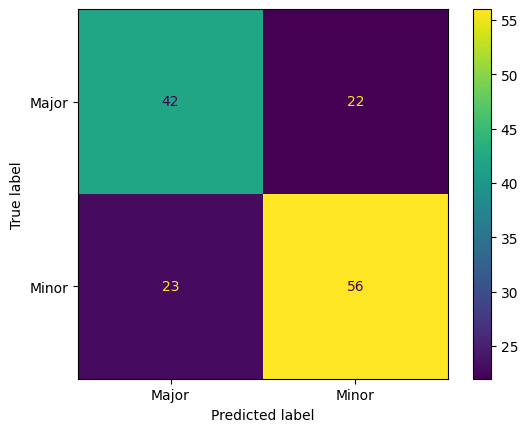


ROC curve:


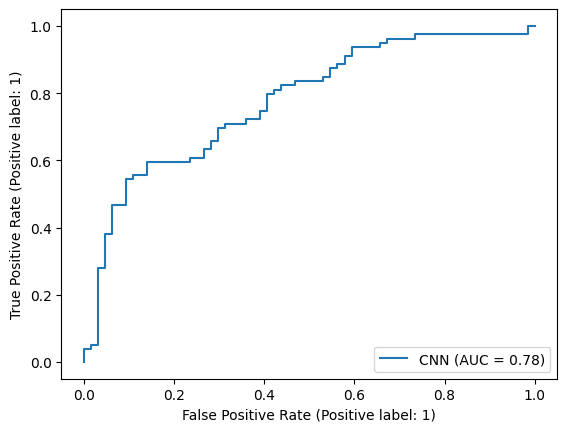

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

# create train-test partitions
inputs_train, inputs_test, targets_train, targets_test = train_test_split(mfcc, labels, test_size=0.2)
inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs_train, targets_train, test_size=0.2)
targets_train = np.array(targets_train)
targets_val = np.array(targets_val)
targets_test = np.array(targets_test)

# tune on MFCC
# best_parameters = tune_CNN(inputs_train, targets_train)
best_parameters = {'input_shape': (93, 13, 1), 'n_filters': 32, 'n_neurons': 16, 'size_filters': 3}

# train on MFCC with best parameters
cnn = train_CNN(inputs_train, inputs_val, targets_train, targets_val, best_parameters)

# evaluate CNN on the test set
evaluate_CNN(cnn, inputs_test, targets_test)

## Train and test on chroma

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 9, 128)        2176      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 5, 128)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 45, 5, 128)       512       
 ormalization)                                                   
                                                                 
 flatten_9 (Flatten)         (None, 28800)             0         
                                                                 
 dense_36 (Dense)            (None, 16)                460816    
                                                                 
 dense_37 (Dense)            (None, 2)                

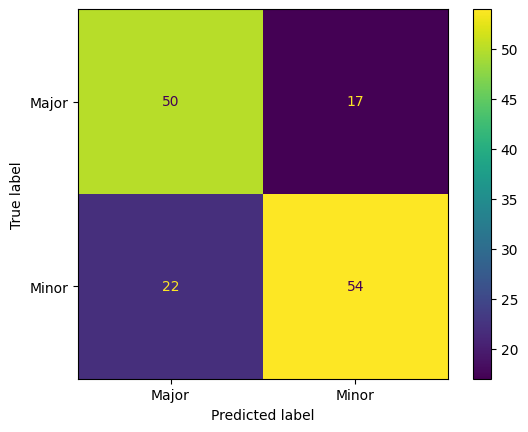


ROC curve:


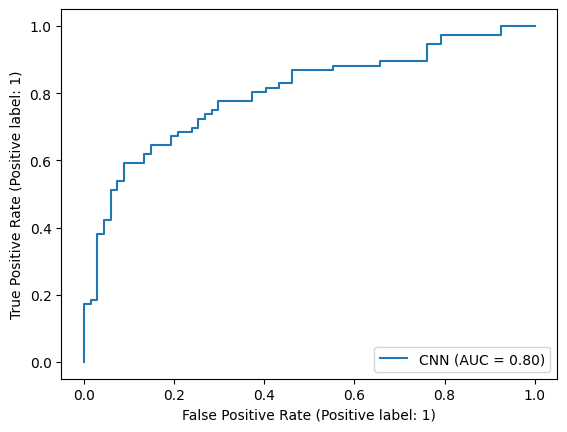

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

# create train-test partitions
inputs_train, inputs_test, targets_train, targets_test = train_test_split(chroma, labels, test_size=0.2)
inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs_train, targets_train, test_size=0.2)
targets_train = np.array(targets_train)
targets_val = np.array(targets_val)
targets_test = np.array(targets_test)

# tune on chroma
# best_parameters = tune_CNN(inputs_train, targets_train)
best_parameters = {'input_shape': (93, 12, 1), 'n_filters': 128, 'n_neurons': 16, 'size_filters': 4}

# train on chroma with best parameters
cnn = train_CNN(inputs_train, inputs_val, targets_train, targets_val, best_parameters)

# evaluate CNN on the test set
evaluate_CNN(cnn, inputs_test, targets_test)